# Toxic Comment Classification EDA

In [2]:
!pip install watermark -q

# Table of Contents

* [Introduction](#introduction)
* [Checking Unique Value](#unique)
* [Clean Comments Count](#clean)
* [Calculating numbers of Comments in each category](#idc)
* [Comments having multiple Labels](#idc2)
* [Most Frequent Words](#idc3)
* [Labels Distribution](#idc4)
* [Observation](#idc5)
* [Training Data Generation](#idc6)

# Introduction <a id="introduction"></a>

In this notebook is my first attempt of a thorough analysis of this dataset.

## Load data and summary

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import random
import torch
import string
import re
import nltk
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
plt.style.use('seaborn')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv.zip
/kaggle/input/jigsaw-toxic-comment-classification-challenge/sample_submission.csv.zip
/kaggle/input/jigsaw-toxic-comment-classification-challenge/test_labels.csv.zip
/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv.zip


In [4]:
%load_ext watermark

In [5]:
%watermark --iversions

seaborn   : 0.11.2
torch     : 1.11.0+cpu
matplotlib: 3.5.3
re        : 2.2.1
numpy     : 1.21.6
nltk      : 3.7
pandas    : 1.3.5



## Seed Everything

So we can produce same results again

In [6]:
DEFAULT_SEED: int = 1234

random.seed(DEFAULT_SEED)
np.random.seed(DEFAULT_SEED)  
torch.manual_seed(DEFAULT_SEED)
torch.cuda.manual_seed(DEFAULT_SEED)

In [7]:
train_df = pd.read_csv("/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv.zip")
train_df.shape

(159571, 8)

In [8]:
train_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [10]:
train_df.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Checking Unique Values <a id="unique"></a>

In [11]:
train_df.nunique()

id               159571
comment_text     159571
toxic                 2
severe_toxic          2
obscene               2
threat                2
insult                2
identity_hate         2
dtype: int64

## Checking Comment Lenght

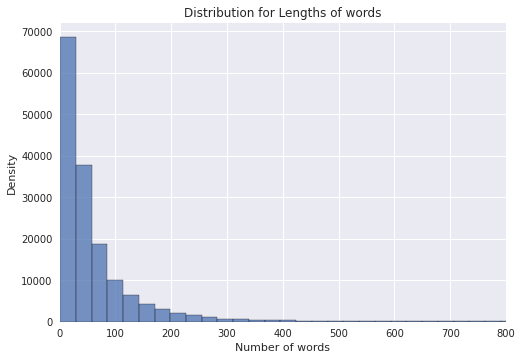

In [12]:
comment_length = train_df['comment_text'].str.split().apply(len)
sns.histplot(comment_length,bins=50,)
plt.title("Distribution for Lengths of words")
plt.xlabel("Number of words")
plt.ylabel("Density")
plt.xlim(0, 800)
plt.show()

## Checking missing values

In [13]:
train_df.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

# Clean Comments Count <a id="clean"></a>

 - Creating seperate column in dataframe to identify clean comments.
 -We use axis=1 to count row-wise and axis=0 to count column wise

In [14]:
rowSums = train_df.iloc[:,2:].sum(axis=1)
clean_comments_count = (rowSums==0).sum(axis=0)

print("Total number of comments = ",len(train_df))
print("Number of clean comments = ",clean_comments_count)
print("Number of comments with labels =",(len(train_df)-clean_comments_count))



Total number of comments =  159571
Number of clean comments =  143346
Number of comments with labels = 16225


## Calcualte percentage of rows with only zeros in training labels

In [15]:
print(f"{round(clean_comments_count /len(train_df),3)} % percentage of rows contains only zeros in training data")

0.898 % percentage of rows contains only zeros in training data


## Labels

In [16]:
categories = list(train_df.columns.values)
categories = categories[2:]
print(categories)

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']


# Calculating Number of Comments in each Category <a id="idc"></a>

In [17]:
counts = []
for category in categories:
    counts.append((category, train_df[category].sum()))
df_stats = pd.DataFrame(counts, columns=['category', 'number of comments'])
df_stats

,category,number of comments
0,toxic,15294
1,severe_toxic,1595
2,obscene,8449
3,threat,478
4,insult,7877
5,identity_hate,1405


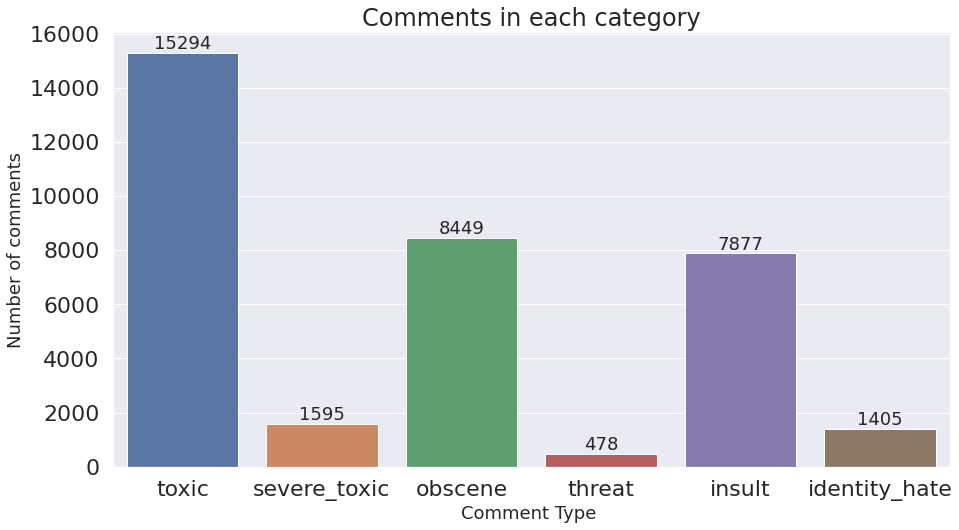

In [18]:
sns.set(font_scale = 2)
plt.figure(figsize=(15,8))

ax= sns.barplot(x=categories, y=train_df.iloc[:,2:].sum().values)

plt.title("Comments in each category", fontsize=24)
plt.ylabel('Number of comments', fontsize=18)
plt.xlabel('Comment Type ', fontsize=18)

#adding the text labels
rects = ax.patches
labels = train_df.iloc[:,2:].sum().values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=18)

plt.show()

# Comments having multiple labels <a id="idc2"></a>

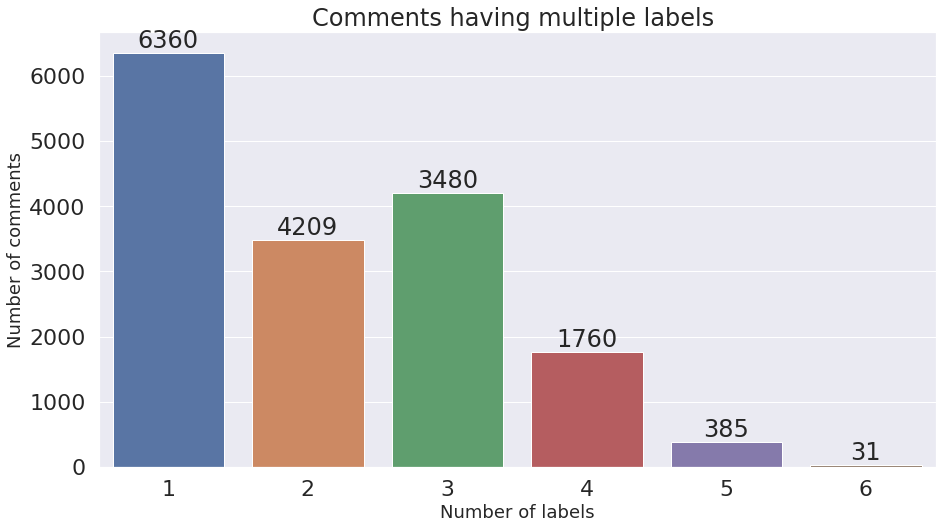

In [19]:
rowSums = train_df.iloc[:,2:].sum(axis=1)
multiLabel_counts = rowSums.value_counts()
multiLabel_counts = multiLabel_counts.iloc[1:]

sns.set(font_scale = 2)
plt.figure(figsize=(15,8))

ax = sns.barplot(x=multiLabel_counts.index, y=multiLabel_counts.values)

plt.title("Comments having multiple labels ")
plt.ylabel('Number of comments', fontsize=18)
plt.xlabel('Number of labels', fontsize=18)

#adding the text labels
rects = ax.patches
labels = multiLabel_counts.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

# Most frequent words in the dataset <a id="idc3"></a>

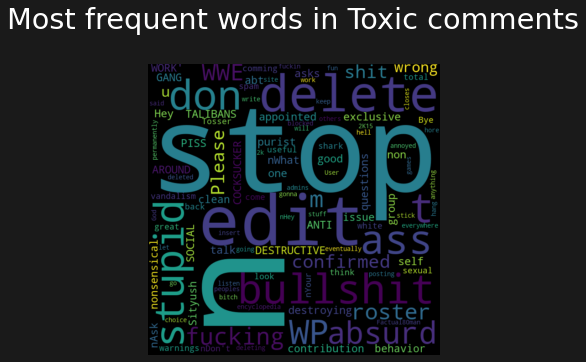

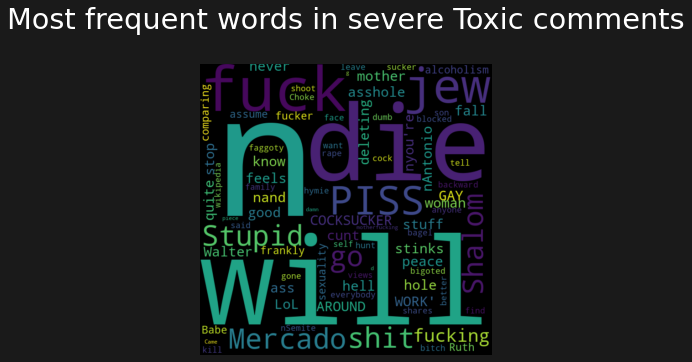

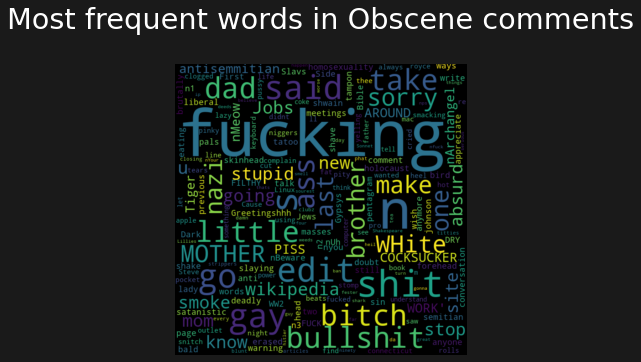

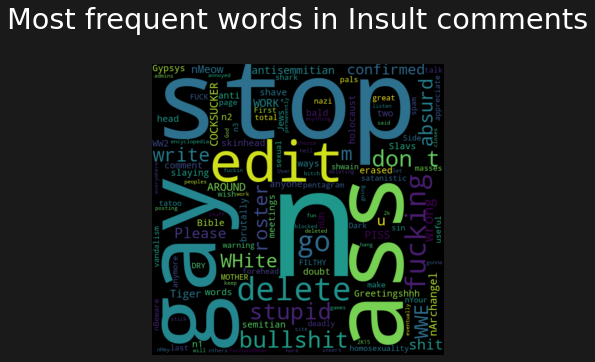

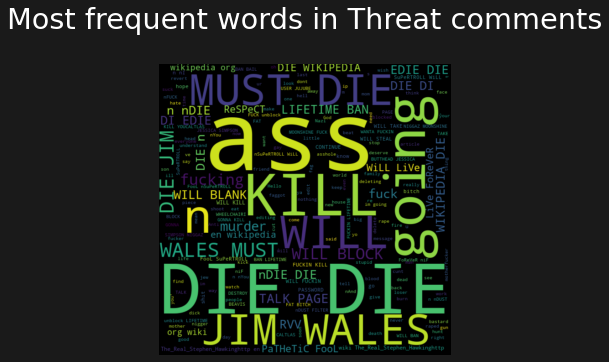

In [20]:
def word_plot(column,text):
    
    comments = train_df['comment_text'].loc[column == 1].values     # sort by toxicity
    
    word_cloud = WordCloud( width = 640, height = 640, background_color = 'black',
                stopwords = STOPWORDS).generate(str(comments))     # stopwords are a,an,the
    
    fig = plt.figure( figsize = (8, 5), facecolor = 'k', edgecolor = 'k')
    plt.subplot()
    plt.imshow(word_cloud, interpolation = 'bilinear')
    plt.suptitle("Most frequent words in " +  text , y = 1.06,color = "white")
    plt.tight_layout(pad = 0)
    plt.axis('off')
    plt.show()
    
word_plot(train_df['toxic'], "Toxic comments")
word_plot(train_df['severe_toxic'],"severe Toxic comments")
word_plot(train_df['obscene'],"Obscene comments")
word_plot(train_df['insult'],"Insult comments")
word_plot(train_df['threat'],"Threat comments")

## Unique words count distribution

In [21]:
count_word = train_df["comment_text"].apply(lambda x: len(str(x).split()))
#Unique word count
count_unique_word = train_df["comment_text"].apply(lambda x: len(set(str(x).split())))

In [22]:
unique_percent = count_unique_word*100/count_word
unique_percent

0          95.348837
1         100.000000
2          92.857143
3          72.566372
4         100.000000
             ...    
159566     93.617021
159567    100.000000
159568    100.000000
159569     92.000000
159570     88.888889
Name: comment_text, Length: 159571, dtype: float64

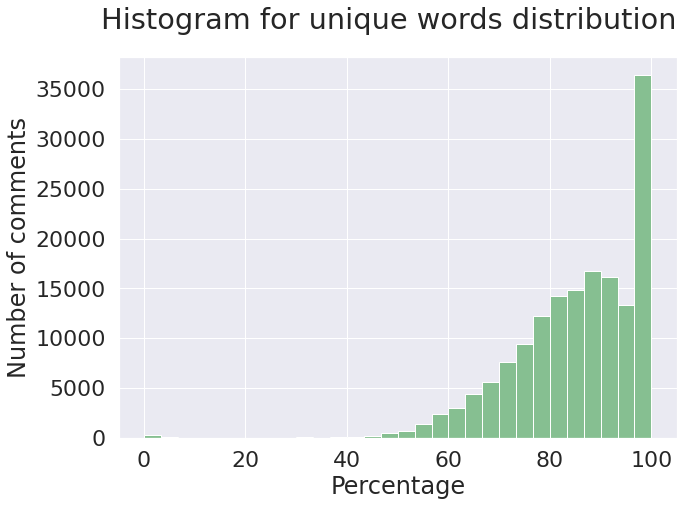

In [23]:
# plot unique words distribution for comments
unique_percent.hist(bins=30, figsize=(10,7), color='#86bf91')
plt.suptitle("Histogram for unique words distribution")
plt.xlabel("Percentage")
plt.ylabel("Number of comments")
plt.show()

# Labels Distribution <a id="idc4"></a>

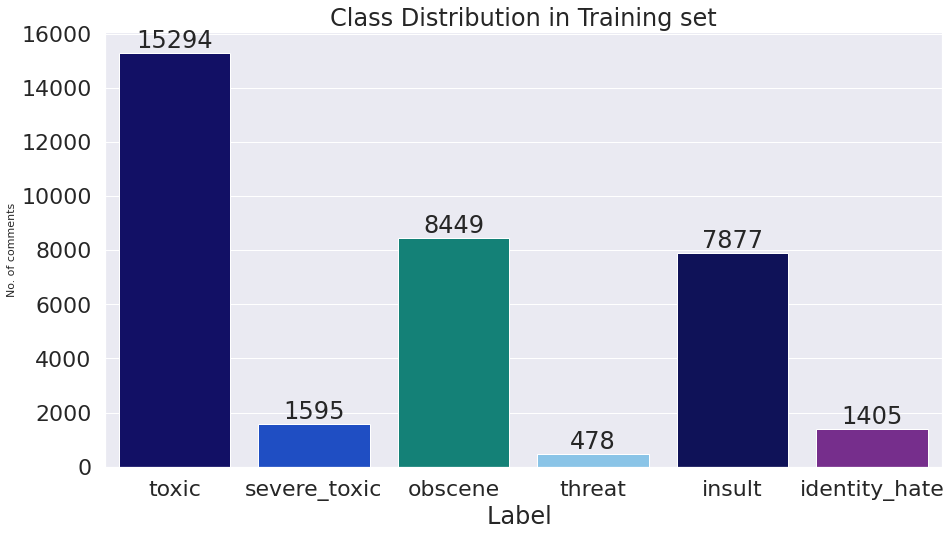

In [24]:
colors_ = ["deep blue","blue", "teal", "lightblue","darkblue","purple"]

palette= sns.xkcd_palette(colors_)

x = train_df.iloc[:,2:].sum()

plt.figure(figsize=(15,8))

ax= sns.barplot(x=x.index,y=x.values,palette=palette)
plt.title("Class Distribution in Training set")
plt.xlabel('Label ')
plt.ylabel('No. of comments', fontsize=11)

patch = ax.patches
labels = x.values
for rect, label in zip(patch, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 10, label, va='bottom',ha='center')

plt.show()

## Plot Distribution of Training Labels

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  This is separate from the ipykernel package so we can avoid doing imports until


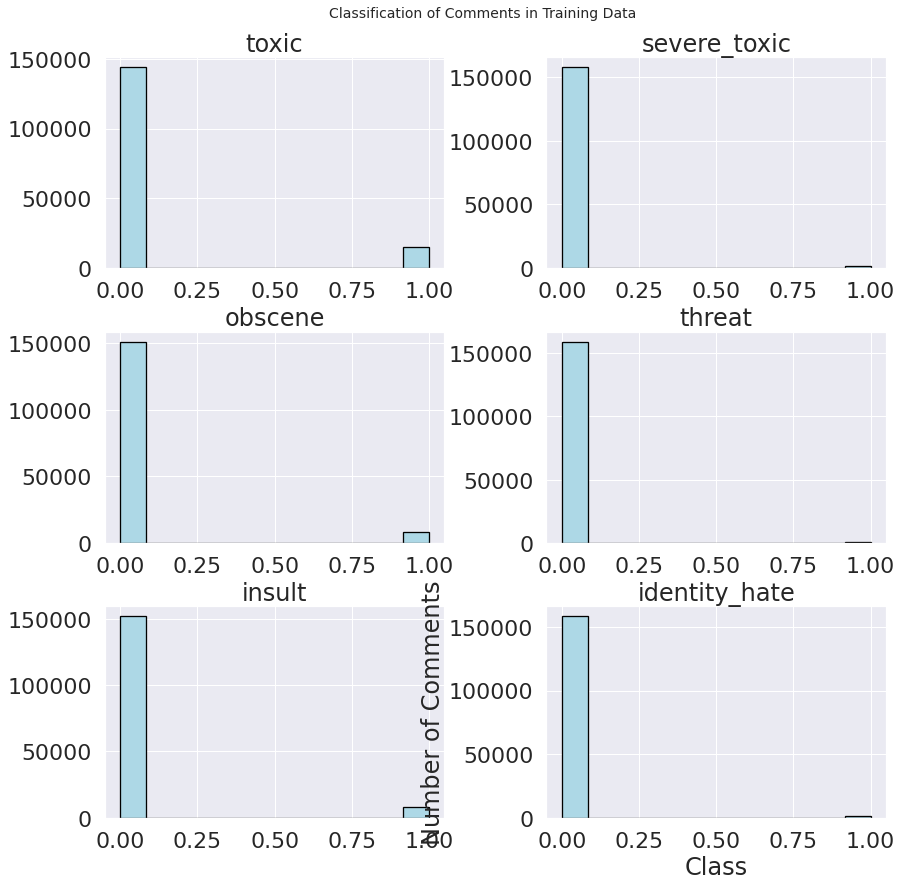

In [25]:
fig = plt.figure(figsize = (14,14))
ax = fig.gca()
train_df.hist(ax = ax,edgecolor = 'black',facecolor = 'lightblue',bins = 12,linewidth = 1.3)
plt.suptitle('Classification of Comments in Training Data',y = 0.93,size = 14)
plt.xlabel("Class")
plt.ylabel("Number of Comments")
plt.show()

# It can be observed that there is a high imbalance among the classes
# Most of the values are zero for all classes

## Heatmap for training data


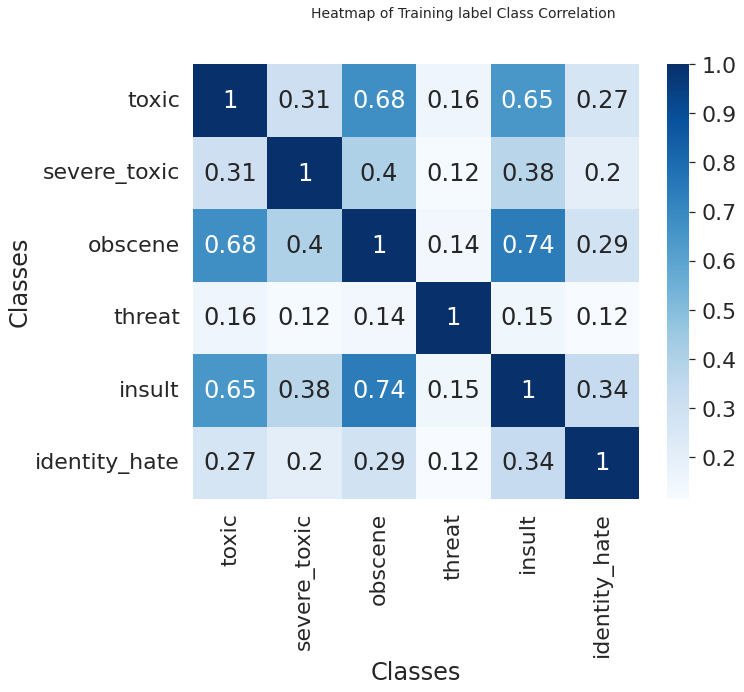

In [26]:
fig = plt.figure(figsize = (10,8))
sns.heatmap(train_df.corr(), annot=True,cmap="Blues")
plt.suptitle('Heatmap of Training label Class Correlation',size = 14)
plt.xlabel("Classes")
plt.ylabel("Classes")
plt.show()

In [27]:
correlation_val =  train_df.corr()
correlation_val

,toxic,severe_toxic,obscene,threat,insult,identity_hate
toxic,1.000000,0.308619,0.676515,0.157058,0.647518,0.266009
severe_toxic,0.308619,1.000000,0.403014,0.123601,0.375807,0.201600
obscene,0.676515,0.403014,1.000000,0.141179,0.741272,0.286867
threat,0.157058,0.123601,0.141179,1.000000,0.150022,0.115128
insult,0.647518,0.375807,0.741272,0.150022,1.000000,0.337736
identity_hate,0.266009,0.201600,0.286867,0.115128,0.337736,1.000000


In [28]:
abs(correlation_val) >= 0.6

,toxic,severe_toxic,obscene,threat,insult,identity_hate
toxic,True,False,True,False,True,False
severe_toxic,False,True,False,False,False,False
obscene,True,False,True,False,True,False
threat,False,False,False,True,False,False
insult,True,False,True,False,True,False
identity_hate,False,False,False,False,False,True


Some classes are highly positively corelated to others Correlation>60%

-toxic and insult (0.6475)
- toxic and obscene (0.6765)
- obscene and insult (0.7412)
  
This means that if a comment is toxic then there is a 67.6% chance it is also obscene and 64.7% chance that it is also classified as insult.
Obscene and insult comments are the most correlated with correlation of 74.1%

In [29]:
print("Distribution of Training Classes in Percentage:")
print()

print((train_df['toxic'].value_counts()/159571)*100)
print()
print(train_df['severe_toxic'].value_counts()/159571 *100)
print()
print(train_df['obscene'].value_counts()/159571 *100)
print()
print(train_df['threat'].value_counts()/159571 *100)
print()
print(train_df['insult'].value_counts()/159571 *100)
print()
print(train_df['identity_hate'].value_counts()/159571 *100)
print()

Distribution of Training Classes in Percentage:

0    90.415552
1     9.584448
Name: toxic, dtype: float64

0    99.000445
1     0.999555
Name: severe_toxic, dtype: float64

0    94.705178
1     5.294822
Name: obscene, dtype: float64

0    99.700447
1     0.299553
Name: threat, dtype: float64

0    95.063639
1     4.936361
Name: insult, dtype: float64

0    99.119514
1     0.880486
Name: identity_hate, dtype: float64



# Observation <a id="idc5"></a>

- It can be observed that most of the values are 0
- Very few percentage of values in classes as labelled as 1 which means there is a high imbalance of classes
- Class "threat" has the highest imbalance with only 0.29% of classes labeled as 1. This means that it would be difficult to classify this class correctly in the test set as very few comments being a threat are present.
- Some undersampling or oversampling should be performed to remove imbalance
- Stratified sampling by splitting data into training and validation will also be done


- 143346 rows out of 159571 rows in training data do not have any label as 1.
- Or in other words approx 90% of the comments are untoxic.
- There is a high chance of overfitting and getting a good accuracy with a model which predicts almost all comments as not toxic.
- The problem is to fit the data such that it also predicts the toxicity and the type of toxicity accurately.

# Training and Test Data Generation <a id="idc6"></a>

# Under Sampling

- SMOTE(Synthetic Minority Oversampling Technique), RandomOverSampler and RandomUnderSampler are efficient techniques to perform oversampling or undersampling but - it does not work well when there is a huge imbalance in the dataset and there are very few samples for a particular class. So these techniques do not fit well with this dataset.
- I will perform Under Sampling by dropping a few rows of data.
- I will drop 50% of comments which have labels as all zeros.
- I have chosen this number so that i do not decrease the dataset by a large amount and still have enough comments which are not toxic to train the model in an efficient manner.

## Method 1

<AxesSubplot:>

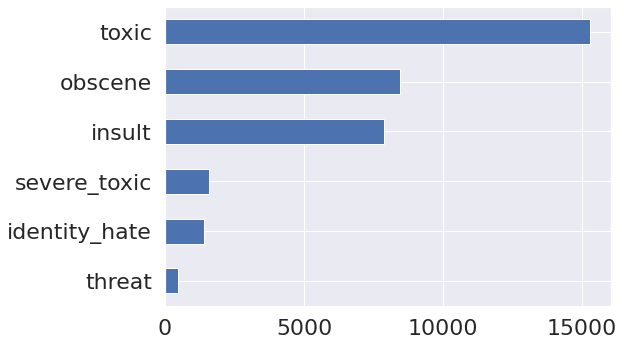

In [30]:
train_df[categories].sum().sort_values().plot(kind="barh")

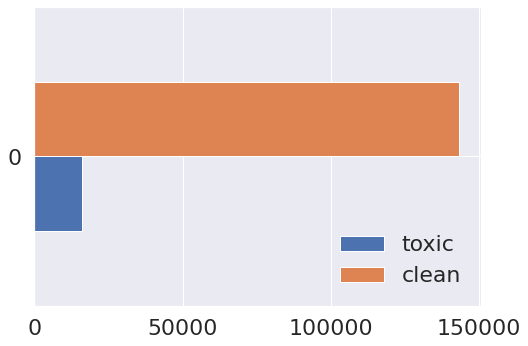

In [31]:
train_toxic_comments = train_df[train_df[categories].sum(axis=1) > 0]
train_clean_comments = train_df[train_df[categories].sum(axis=1) == 0]

pd.DataFrame(dict(
  toxic=[len(train_toxic_comments)],
  clean=[len(train_clean_comments)]
)).plot(kind='barh');

In [32]:
custom_training_df = pd.concat([
  train_toxic_comments,
  train_clean_comments.sample(15_000)
])

In [33]:
custom_training_df.shape

(31225, 8)

In [34]:
custom_training_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
12,0005c987bdfc9d4b,Hey... what is it..\n@ | talk .\nWhat is it......,1,0,0,0,0,0
16,0007e25b2121310b,"Bye! \n\nDon't look, come or think of comming ...",1,0,0,0,0,0
42,001810bf8c45bf5f,You are gay or antisemmitian? \n\nArchangel WH...,1,0,1,0,1,1
43,00190820581d90ce,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1,0,1,0,1,0


## Method 2

In [35]:
y = train_df.iloc[:,2:].values
zero_rows_y = np.where(~y.any(axis=1))[0]

In [36]:
zero_rows_y

array([     0,      1,      2, ..., 159568, 159569, 159570])

## Verify labels with clean comment 

In [37]:
y[109570]

array([0, 0, 0, 0, 0, 0])

In [38]:
y[0]

array([0, 0, 0, 0, 0, 0])

In [39]:
y[159568]

array([0, 0, 0, 0, 0, 0])

In [40]:
print("Rows with zeros in training labels: ",zero_rows_y.shape) #check shape
print("Shape of training labels          : ", y.shape)

Rows with zeros in training labels:  (143346,)
Shape of training labels          :  (159571, 6)


## Calculating 50% of labels with rows with only zeros


In [41]:
(143346*50)/100

71673.0

In [42]:
# Get index  where rows of training labels are zeros
drop_rows_indx = zero_rows_y[0:71673] # store indexes of first 71,673 such rows
drop_rows_indx 

array([    0,     1,     2, ..., 79875, 79876, 79877])

In [43]:
drop_rows_indx.shape

(71673,)


# Investigating Prevalence of Certain Characters in Toxic Comments:


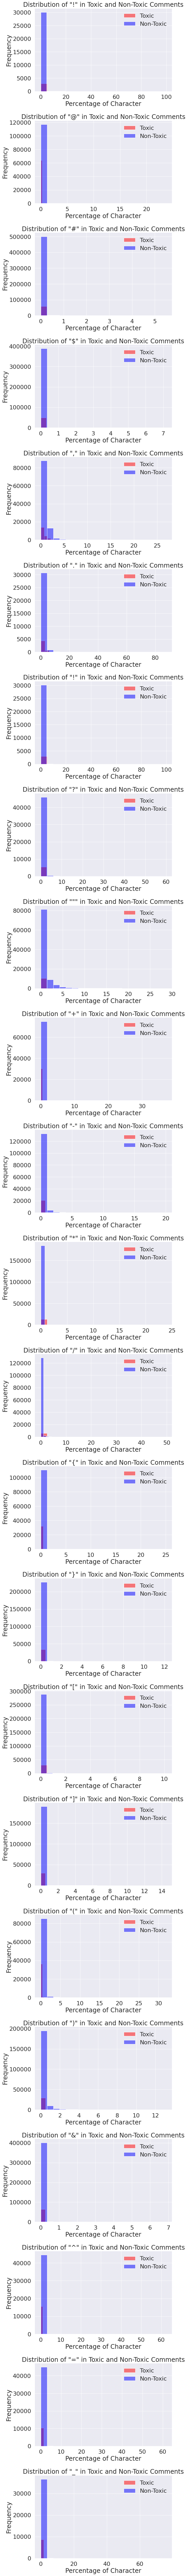

In [58]:
# Choose a list of specific characters to investigate
characters_to_investigate = ['!', '@', '#', '$', ',', '.', '!', '?', '"', '+', '-', '*', '/', '{', '}', '[', ']', '(', ')', '&', '^', '=', '_']

# Set colors for toxic and non-toxic histograms
toxic_color = 'red'
non_toxic_color = 'blue'

# Create subplots for each character
fig, axes = plt.subplots(nrows=len(characters_to_investigate), ncols=1, figsize=(10, 6 * len(characters_to_investigate)))

for i, character_to_investigate in enumerate(characters_to_investigate):
    # Calculate the percentage of the chosen character in toxic comments
    toxic_percentage = train_df[train_df['toxic'] == 1]['comment_text'].apply(
        lambda x: (x.lower().count(character_to_investigate.lower()) / len(x)) * 100
    )

    # Calculate the percentage of the chosen character in non-toxic comments
    non_toxic_percentage = train_df[train_df['toxic'] == 0]['comment_text'].apply(
        lambda x: (x.lower().count(character_to_investigate.lower()) / len(x)) * 100
    )

    # Plot the distribution of the chosen character in toxic vs. non-toxic comments with custom colors
    ax = axes[i]
    ax.set_title(f'Distribution of "{character_to_investigate}" in Toxic and Non-Toxic Comments')
    sns.histplot(toxic_percentage, bins=20, color=toxic_color, alpha=0.5, label='Toxic', stat='frequency', ax=ax)
    sns.histplot(non_toxic_percentage, bins=20, color=non_toxic_color, alpha=0.5, label='Non-Toxic', stat='frequency', ax=ax)
    ax.set_xlabel('Percentage of Character')
    ax.set_ylabel('Frequency')
    ax.legend()

plt.tight_layout()
plt.show()


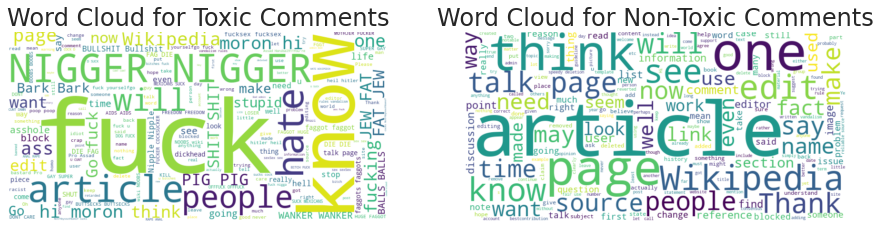

In [59]:
from wordcloud import WordCloud

# Combine all comments for toxic and non-toxic categories
toxic_comments = ' '.join(train_df[train_df['toxic'] == 1]['comment_text'])
non_toxic_comments = ' '.join(train_df[train_df['toxic'] == 0]['comment_text'])

# Generate Word Clouds for Toxic and Non-Toxic Comments
plt.figure(figsize=(15, 7))

# Word Cloud for Toxic Comments
plt.subplot(1, 2, 1)
wordcloud_toxic = WordCloud(width=800, height=400, background_color='white').generate(toxic_comments)
plt.imshow(wordcloud_toxic, interpolation='bilinear')
plt.title('Word Cloud for Toxic Comments')
plt.axis('off')

# Word Cloud for Non-Toxic Comments
plt.subplot(1, 2, 2)
wordcloud_non_toxic = WordCloud(width=800, height=400, background_color='white').generate(non_toxic_comments)
plt.imshow(wordcloud_non_toxic, interpolation='bilinear')
plt.title('Word Cloud for Non-Toxic Comments')
plt.axis('off')

plt.show()
